<a href="https://colab.research.google.com/github/marcosabdalla/Intro_Manutencao_Preditiva/blob/main/Sim_Manut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplificação de um processo de Manutenção Preditiva

Vamos supor que temos uma bomba de água e esta bomba tem sensores que monitoram a vazão da água que flui por ela e a velocidade de rotação do eixo. Para este exemplo, vamos considerar que o funcionamento normal temos que, em baixa rotação, a vazão do líquido é baixa e em alta rotação, a vazão é alta. Qualquer atividade fora dessas duas condições de normalidade, podemos considerar como defeito na bomba. Aqui o termo "defeito" será genérico, logo não vamos definir o tipo de defeito!

# Vamos começar importando as bibliotecas necessárias:

In [ ]:
import numpy as np # Biblioteca matemática
import matplotlib.pyplot as plt # Biblioteca para criação de gráficos
from sklearn import datasets # Biblioteca de onde sairá os dados
from tensorflow.keras.optimizers import Adam # Otimizador
import keras # Biblioteca responsável pelo desenvolvimento da Rede Neural
from keras.models import Sequential # Biblioteca responsável pelo desenvolvimento da Rede Neural
from keras.layers import Dense # Biblioteca responsável pelo desenvolvimento da Rede Neural
from keras.utils.np_utils import to_categorical # Biblioteca responsável pelo desenvolvimento da Rede Neural
import pandas as pd # Biblioteca usada para organizar os dados.

Criar uma função que mostra as regiões de operação da bomba e define também uma fronteira entre as condições.

In [ ]:
def plot_decision_boundary(X, y_cat, model):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0]) + 0.25,50)
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1]) + 0.25,50)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_, yy_]
    pred_func = np.argmax(model.predict(grid), axis=-1)
    z = pred_func.reshape(xx.shape)
    plt.contourf(xx, yy, z)

# Criar os dados
Vamos supor que os sensores acoplados na bomba, entregaram 3 tipos de dados:


*   Bomba operando com alta rotação e alta vazão (normal)
*   Bomba operando com baixa rotação e baixa vazão (normal)
*   Bomba operando com alta rotação e baixa vazão (falha)

Estes dados serão criados na forma de grupos (ou clusters) com centros definidos em um ponto do plano cartesiano (x,y) e ao redor destes pontos vamos sortear aleatoriamente os pontos. Vamos propor então um centro em (1,1) que é uma condição de operação normal, um centro em (5,5) que também é uma operação normal e por fim um centro em (1,4) que será o centro da região de operação com falha.



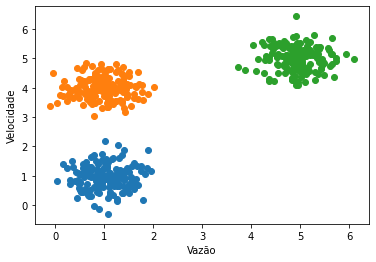

In [ ]:
n_pts = 500 # Numeros de pontos espalhados pelos 3 centrole
centros = [[1, 1],[1, 4] , [5, 5]] # centro dos clustes de dados 0 -> 1,1, 1 -> 1,4, 2 -> 5,5
x1, y1 = datasets.make_blobs(n_samples = n_pts, random_state = 123, centers = centros, cluster_std = 0.4) # cria os dados
# Visualiar os dados
plt.scatter(x1[y1==0, 0], x1[y1==0, 1])
plt.scatter(x1[y1==1, 0], x1[y1==1, 1])
plt.scatter(x1[y1==2, 0], x1[y1==2, 1])
plt.scatter(x1[y1==3, 0], x1[y1==3, 1])
plt.scatter(x1[y1==4, 0], x1[y1==4, 1])
plt.scatter(x1[y1==5, 0], x1[y1==5, 1])
plt.xlabel("Vazão")
plt.ylabel("Velocidade")
plt.show()

Estamos usando aqui um gerador de dados do sklearn que tem o propósito de gerar dados para usar em sistemas de aprendizado de máquina. O interessante dele é que a função make_blobs fornece na saída os dados de entrada "x" e as respectivas classes "y".

Um ponto importante com relação as classes é que neste exemplo, que são 0, 1 e 2, não podem ser utilizadas nesta forma pois a rede pode entender estes números, não como uma classe propriamente dita e sim como valores numéricos. Sendo assim, vamos a seguir criar três classes diferentes usando uma técnica conhecida como one-hot-encode. Assim as classes serão:

* Classe 0: 1,0,0
* Classe 1: 0,1,0
* Classe 2: 0,0,1

In [ ]:
# Cria as 3 classes usando o one-hot-encode
y_cat = to_categorical(y1, 3)

# Criar a rede neural

Ok, então até aqui, criamos os dados que serão utilizados na rede bem como suas respectivas classes. Agora vamos criar a arquitetura da rede que irá classificar os dados.

Primeiro vamos analisar os nossos dados:
A variável x é um vetor de 2 colunas (velocidade e vazão) e 500 linhas. Com essa informação vamos criar a camada de entrada da nossa rede. Ela vai ter então dois valores de entrada, aqui achei interessante passar estes dois valores por três neurônios.
A saída dessa nossa rede deve ser um valor que represente a probabilidade de ser uma das 3 classes. Logo, nossa camada de saída terá 3 neurônios. 

Por exemplo, suponha que para uma velocidade de 1.1 e uma vazão de 0.5, a saída da rede seja: $[0.90, 0.04, 0.06]$ então a rede esta indicando que existe uma probabilidade de 90% dessa operação ser da classe 0.

In [ ]:
def cria_modelo():
  modelo = keras.Sequential([
                            Dense(3, activation='relu', input_shape = (2,)), # Camada de entrada
                            Dense(3, activation='softmax')]) # Camada de saida
  return modelo
modelo = cria_modelo()
#modelo.summary()

modelo.compile(Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
modelo.fit(x = x1, y = y_cat, verbose = 0, batch_size = 25, epochs = 140, shuffle = 'true')
# Os dados serão enviados em bateladas de 25 valores
# O treinamento será realizado em 130 épocas (a princípio...)
# Para não ficar vendo a saída da rede, mude o verbose para 0

No código acima temos alguns parâmetros que merecem ser comentados. Vamos começar pelas camadas da rede. Essas duas camadas são criadas como Densas (Dense) isso quer dizer que todos os neurônios de uma camada, estão conectados a todos os neurônios da camada seguinte. Depois disso temos duas funções de ativação;

A ReLU que em inglês significa Rectified Linear Unit e a

Softmax que é usada na classificação de múltiplas classes.

E o otimizador utilizado é o Adam que é um algorítmo que implementa a descida do gradiente estocástica.

Obs:. para aqueles que entendem mais sobre aprendizado de máquina... sim eu usei todos os dados para treinamento da rede e o motivo é que eu não estou interessado em mostrar o quão bom é essa rede... e sim demonstrar o que ela pode fazer! Ok?

# Visualizar as regiões de operação

Com a rede devidamente treinada, podemos visualizar as três diferentes regiões que propusemos para a operação da bomba. Para melhor visualizar, coloquei também os dados de treinamento.

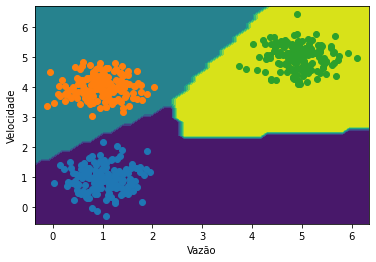

In [ ]:
plot_decision_boundary(x1, y_cat, modelo)
plt.scatter(x1[y1==0, 0], x1[y1==0, 1])
plt.scatter(x1[y1==1, 0], x1[y1==1, 1])
plt.scatter(x1[y1==2, 0], x1[y1==2, 1])
plt.scatter(x1[y1==3, 0], x1[y1==3, 1])
plt.scatter(x1[y1==4, 0], x1[y1==4, 1])
plt.scatter(x1[y1==5, 0], x1[y1==5, 1])
plt.xlabel("Vazão")
plt.ylabel("Velocidade")
plt.show()

# Testar a rede

É comum separar parte dos dados coletados em dados de treinamento e dados de validação. No entanto para manter um exemplo simplificado, achei melhor usar todos os dados para treinar a rede e eu mesmo criar dados que simulem a tomada de amostras com o passar do tempo.

Vamos supor então uma situação ideal onde a máquina acabou de passar por uma manutenção preveniva e está funcionando completamente bem. Supondo então que o mês de análise dos dados da bomba, tenha 4 semanas.
No final da primeira semana os valores dos sensores foi (1,1). No final da segunda semana (1,1.33), no final da terceira (1,1.67) e no final da última semana (1,2). De modo a mostrar que de uma semana para outra vazão permaneceu contante apesar do aumento da velocidade.

In [ ]:
# Criar os dados de teste
lmin = 1 # Valor minimo
lmax = 2 # Valor máximo
pts = 4 # Numero de amostras (1 por semana)
vel = np.linspace(lmin,lmax,pts) # Cria um vetor com os dados
vaz = np.ones(len(vel))

In [ ]:
dados = pd.DataFrame(vel, columns = ["Velocidade"])
dados.insert(1,"Vazao",vaz)
dados

,Velocidade,Vazao
0,1.000000,1.0
1,1.333333,1.0
2,1.666667,1.0
3,2.000000,1.0


In [ ]:
# Organizar os dados para serem passados pela rede
Dados = dados.to_numpy()
Dados

array([[1.        , 1.        ],
       [1.33333333, 1.        ],
       [1.66666667, 1.        ],
       [2.        , 1.        ]])

Vamos enviar os dados para a rede criada e olhar as previsões

In [ ]:
P = []
for i in range(len(Dados)):
  point = np.array([[Dados[i,1], Dados[i,0]]])
  P.append(point)
  #pred = np.argmax(modelo.predict(point), axis=-1)
  pred = modelo.predict(point)
  print(pred)


[[0.98137605 0.00761562 0.01100829]]
[[0.96345    0.02340848 0.01314146]]
[[0.91520053 0.06961993 0.01517961]]
[[0.79469734 0.18927483 0.01602788]]


Para todos os dados apresentados para a rede, foi dado como funcionamento normal. No entanto é possível observar uma movimentação do ponto de funcionamento da máquina para a região de falha.

Observe os valores da primeira coluna e os valores da segunda coluna. Vemos aqui uma diminuição da probabilidade de opração normal (primeira coluna) e um aumento da probabilidade de operação com falha (segunda coluna).

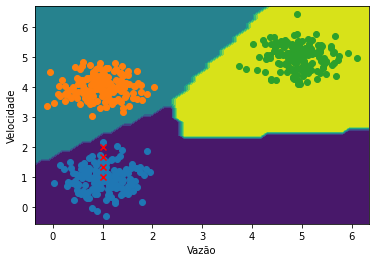

In [ ]:
plot_decision_boundary(x1, y_cat, modelo)
plt.scatter(x1[y1==0, 0], x1[y1==0, 1])
plt.scatter(x1[y1==1, 0], x1[y1==1, 1])
plt.scatter(x1[y1==2, 0], x1[y1==2, 1])
plt.scatter(x1[y1==3, 0], x1[y1==3, 1])
plt.scatter(x1[y1==4, 0], x1[y1==4, 1])
plt.scatter(x1[y1==5, 0], x1[y1==5, 1])
plt.scatter(dados['Vazao'],dados['Velocidade'], marker = 'x', color = "r")
plt.xlabel("Vazão")
plt.ylabel("Velocidade")
plt.show()

Vamos continuar a usar esta máquina, mesmo vendo que ela tende para a falha apenas para ver o que a rede nos mostra.

[[0.79469734 0.18927483 0.01602788]]
[[0.2972155  0.693921   0.00886351]]
[[0.04178693 0.95637053 0.00184261]]
[[4.4361837e-03 9.9527454e-01 2.8924321e-04]]


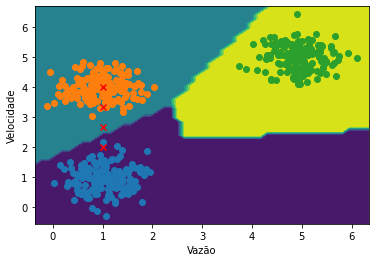

In [ ]:
lmin = 2 # Valor minimo
lmax = 4 # Valor máximo
pts = 4 # Numero de amostras (1 por semana)
vel = np.linspace(lmin,lmax,pts) # Cria um vetor com os dados
vaz = np.ones(len(vel))

dados2 = pd.DataFrame(vel, columns = ["Velocidade"])
dados2.insert(1,"Vazao",vaz)

Dados2 = dados2.to_numpy()

for i in range(len(Dados2)):
  point = np.array([[Dados2[i,1], Dados2[i,0]]])
  #pred = np.argmax(modelo.predict(point), axis=-1)
  pred = modelo.predict(point)
  print(pred)

plot_decision_boundary(x1, y_cat, modelo)
plt.scatter(x1[y1==0, 0], x1[y1==0, 1])
plt.scatter(x1[y1==1, 0], x1[y1==1, 1])
plt.scatter(x1[y1==2, 0], x1[y1==2, 1])
plt.scatter(x1[y1==3, 0], x1[y1==3, 1])
plt.scatter(x1[y1==4, 0], x1[y1==4, 1])
plt.scatter(x1[y1==5, 0], x1[y1==5, 1])
plt.scatter(dados2['Vazao'],dados2['Velocidade'], marker = 'x', color = "r")
plt.xlabel("Vazão")
plt.ylabel("Velocidade")
plt.show()